# What are the salinity fluxes induced by the GM parametrization?

In [1]:
import os
import sys
import numpy as np
import xarray as xr
import cmocean
import matplotlib
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
matplotlib.rc_file('rc_file_paper')
%config InlineBackend.print_figure_kwargs={'bbox_inches':None}
%load_ext autoreload
%autoreload 2

In [3]:
from paths import path_prace, file_ex_ocn_lpd
from constants import rho_sw
from FW_transport import main, geometry_file, mf_list
from xr_DataArrays import xr_AREA

In [4]:
# ds = xr.open_dataset(f'{path_prace}/Mov/FW_Med_Bering_lpd_0500-0530_monthly.nc')
dt = xr.open_dataset(f'{path_prace}/Mov/FW_SALT_fluxes_lpd_0500-0530_monthly.nc')
def add_dim(da):
    return da.expand_dims('time')
dt_ = xr.open_mfdataset([f'{path_prace}/Mov/FW_SALT_fluxes_lpd_05{y:02d}.nc' for y in np.arange(30)], decode_times=False, preprocess=add_dim).mean('time')

# LR-CESM

In [5]:
ds = xr.open_dataset(file_ex_ocn_lpd)

In [6]:
files = [f'{file_ex_ocn_lpd[:-9]}{y}-{m:02d}.nc' for y in np.arange(500,530) for m in np.arange(1,13)]
ds_ = xr.open_mfdataset(files, decode_times=False)[['ADVS_ISOP','ADVS_SUBM']].mean('time')

```
ADVS_ISOP (time, nlat, nlon) float32
long_name :   Vertically-Integrated S Eddy-Induced Advection Tendency (diagnostic)
units :     cm gram/kilogram/s
grid_loc :     2110
cell_methods :     time: mean

ADVS_SUBM (time, nlat, nlon) float32 
long_name :    Vertically-Integrated S submeso Advection Tendency (diagnostic)
units :      cm gram/kilogram/s
grid_loc :    2110
cell_methods :    time: mean

VNS_SUBM (time, z_t, nlat, nlon) float32
long_name :     Salt Flux Tendency in grid-y Dir due to submeso Vel (diagnostic)
units :     gram/kilogram/s
grid_loc :     3121
cell_methods :     time: mean

HDIFS (time, nlat, nlon) float32
long_name :     Vertically Integrated Horz Diff S tendency
units :     centimeter gram/kilogram/s
grid_loc :    2110
cell_methods :     time: mean

ADVS (time, nlat, nlon) float32
long_name :    Vertically-Integrated S Advection Tendency
units :    centimeter gram/kilogram/s
grid_loc :    2110
cell_methods :    time: mean

N_SALT (time, transport_reg, transport_comp, lat_aux_grid) float32
long_name :     Northward Salt Transport
units :    gram centimeter^3/kg/s
cell_methods :     time: mean

VNS (time, z_t, nlat, nlon) float32
long_name :     Salt Flux in grid-y direction
units :    gram/kilogram/s
grid_loc :     3121
cell_methods :     time: mean

VVEL (time, z_t, nlat, nlon) float32
long_name :     Velocity in grid-y direction
units :    centimeter/s
grid_loc :     3221
cell_methods :     time: mean
```

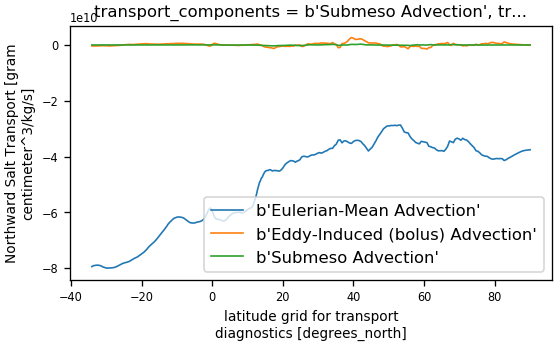

In [7]:
ds.N_SALT.isel(transport_reg=1).isel(transport_comp=1).plot(label=ds.transport_components[1].values)
ds.N_SALT.isel(transport_reg=1).isel(transport_comp=3).plot(label=ds.transport_components[3].values)
ds.N_SALT.isel(transport_reg=1).isel(transport_comp=4).plot(label=ds.transport_components[4].values)
plt.legend()

In [8]:
lats = ds.TLAT.where(ds.REGION_MASK==6).mean('nlon')
Fe_iso = (-rho_sw/1e9/35e6*ds_.ADVS_ISOP*ds.TAREA).where(ds.REGION_MASK==6).sum('nlon').squeeze()
Fe_sub = (-rho_sw/1e9/35e6*ds_.ADVS_SUBM*ds.TAREA).where(ds.REGION_MASK==6).sum('nlon').squeeze()
Fe_mon = -dt.Se.mean('time').rename({'nlat_u':'nlat'})/35e6
Fe_ann = -dt_.Se.rename({'nlat_u':'nlat'})/35e6

Text(0, 0.5, 'eddy freshwater\ntransport  [Sv]')

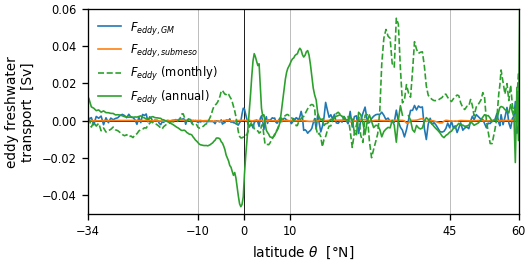

In [9]:
plt.figure(figsize=(4.5,2.25))
plt.axhline(0, lw=.5, c='k')
plt.axvline(0, c='k', lw=.5)
plt.plot(lats, Fe_iso, label=r'$F_{eddy,GM}$')
plt.plot(lats, Fe_sub, label=r'$F_{eddy,submeso}$')
plt.plot(lats, Fe_mon, label=r'$F_{eddy}$ (monthly)', ls='--')
plt.plot(lats, Fe_ann.where(Fe_ann>-0.05), label=r'$F_{eddy}$ (annual)', c='C2')
plt.legend(frameon=False, fontsize=7)
plt.ylim((-0.05,0.06))
plt.xlim((-34,60))
plt.xticks([-34,-10,0,10,45,60])
plt.grid(axis='x', lw=.5)
plt.xlabel(r'latitude $\theta$  [$\degree$N]')
plt.ylabel('eddy freshwater\ntransport  [Sv]')
# plt.savefig('../../results/FW-paper/GM.eps')